# Shoe Images: Real vs. AI Classification Project
In this notebook, I will use the Fastai library to classify shoe images as either real or AI-generated. I won’t classify based on brand (like Nike, Adidas, or Converse). First, I’ll determine whether an image is real or AI-generated. If it’s real and not from Nike, Adidas, or Converse, I’ll label it as “real other.”

## A.1.1. Examination of the Data Structure

Let’s take a look at the structure of the data folders and some sample images.

AI image count: 1356
Real number of images: 825


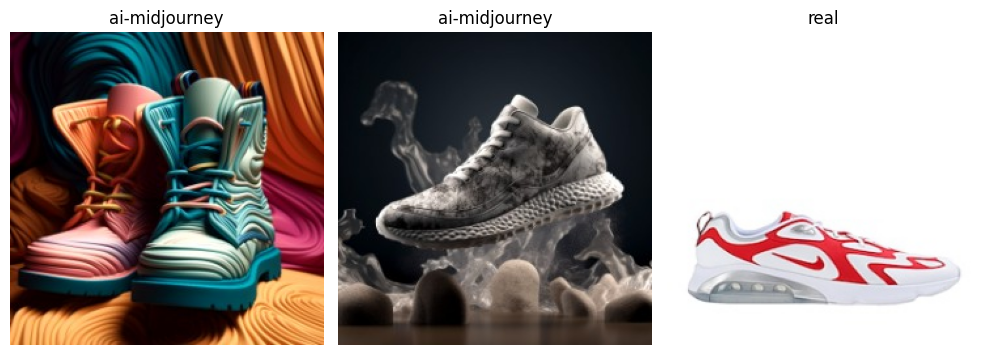

In [8]:
from pathlib import Path
from fastai.vision.all import *
import matplotlib.pyplot as plt

data_path = Path('.')
ai_midjourney_path = data_path/'ai-midjourney'
real_path = data_path/'real'

# Number of files in folders
print(f"AI image count: {len(get_image_files(ai_midjourney_path))}")
print(f"Real number of images: {len(get_image_files(real_path))}")

# Show sample images
fig, axs = plt.subplots(1, 3, figsize=(10,4))
for i, img_path in enumerate(list(get_image_files(ai_midjourney_path))[:2] + list(get_image_files(real_path))[:1]):
    img = PILImage.create(img_path)
    axs[i].imshow(img)
    axs[i].set_title(img_path.parent.name)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

## A.1.2. DataBlock Creation Strategy
Our dataset will have three main classes:

fake: images generated by AI

real_shoe: real images with filenames starting with adidas, nike, or converse

real_other: real images with names consisting only of numbers or any other real images not matching the above brands



# Data Preparation and DataBlock Creation
In this section, I’ll prepare the image dataset using Fastai and set up the DataBlock structure.

In [9]:
from fastai.vision.all import *
from pathlib import Path
import re

## Defining Folder and File Structure
I'll define the data paths and the label extraction function.

In [10]:
# Data paths
data_path = Path('.')
ai_midjourney_path = data_path/'ai-midjourney'
real_path = data_path/'real'

# Label extraction function
def get_label(fn):
    fn = Path(fn)
    if fn.parent.name == 'ai-midjourney':
        return 'fake'
    elif fn.parent.name == 'real':
        name = fn.name.lower()
        # Only those starting with adidas, converse, or nike are labeled 'real_shoe', and those with names made up of only numbers are labeled 'real_other'.
        if name.startswith('adidas') or name.startswith('converse') or name.startswith('nike'):
            return 'real_shoe'
        elif re.match(r'^\d+\.jpg$', name):
            return 'real_other'
        else:
            
            return None
    else:
        return None

## Collecting All Images
I’ll gather all images in the dataset and create a limited subset with only those that can be labeled.

In [14]:
# Collect all images and filter only those that can be labeled.
all_images = get_image_files(ai_midjourney_path) + get_image_files(real_path)
filtered_images = [img for img in all_images if get_label(img) is not None]

# Update get_items=lambda x: filtered_images in the DataBlock.
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: filtered_images,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=Resize(256, method='pad', pad_mode='reflection'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

<Axes: title={'center': 'Augmented örnek (show metodu)'}>

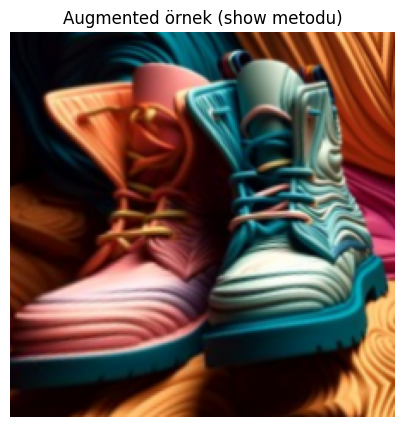

In [ ]:
# Let's show an augmented image with Fastai's show() method
from fastai.vision.augment import aug_transforms
from fastai.vision.all import *

# Choose a sample image (AI or real)
sample_img = get_image_files(ai_midjourney_path)[0]
img = PILImage.create(sample_img)

# PILImage -> TensorImage 
img_tensor = ToTensor()(img).float() / 255.

# Define augmentations
aug_tfms = aug_transforms(size=224, min_scale=0.75)

# Create an augmented image
aug_img_tensor = img_tensor.clone().unsqueeze(0)  # [1, C, H, W]
for t in aug_tfms:
    aug_img_tensor = t(aug_img_tensor)
aug_img_tensor = aug_img_tensor.squeeze(0)  # [C, H, W]

# TensorImage -> PILImage 
aug_img_uint8 = (aug_img_tensor.clamp(0,1) * 255).byte()
aug_img = PILImage.create(aug_img_uint8)


aug_img.show(title="Augmented example ")

## Creating DataLoader and Visualizing Batches
I’ll create DataLoaders from the dataset built with DataBlock and visualize a sample batch.

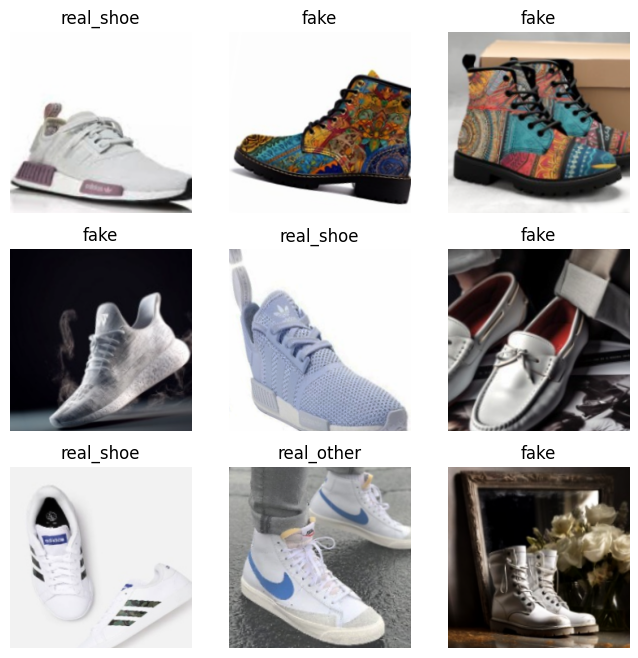

In [20]:
# Create the DataLoaders.
bs = 32

dls = dblock.dataloaders(filtered_images, bs=bs)

dls.show_batch(max_n=9, figsize=(8,8))

## Model Setup and Training
I’ll start training with a ResNet18-based model and use accuracy as the metric during training.

In [21]:
# Build and train the model
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.807395,0.451627,0.855505,01:04


epoch,train_loss,valid_loss,accuracy,time
0,0.400050,0.312219,0.885321,01:06
1,0.280204,0.283343,0.901376,01:07
2,0.245394,0.316154,0.899083,01:06
3,0.182180,0.305345,0.915138,01:08
4,0.125946,0.196736,0.942661,01:08
5,0.084664,0.220347,0.933486,01:06
6,0.063779,0.227414,0.935780,01:05
7,0.041385,0.222826,0.942661,01:07


## Model Evaluation
After training, I’ll evaluate the model’s performance using a confusion matrix and classification report.

              precision    recall  f1-score   support

        fake       1.00      0.99      0.99       268
  real_other       0.89      0.71      0.79        58
   real_shoe       0.85      0.95      0.90       110

    accuracy                           0.94       436
   macro avg       0.91      0.88      0.89       436
weighted avg       0.94      0.94      0.94       436



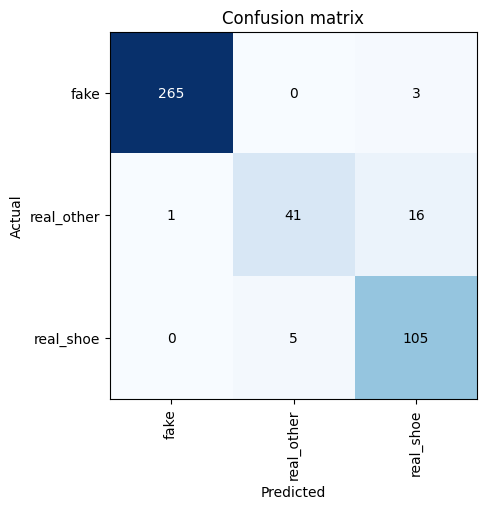

In [22]:
# Estimate and evaluation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))
interp.print_classification_report()

## A.3.3 DataBlock and DataLoader Summary
Let’s summarize the DataLoader to check the data flow and label distribution.

In [23]:

try:
    dls.summary()
except Exception as e:
    print("dls.summary() özeti başarısız oldu:", e)
    # Alternatively, display sample batches and labels
    batch = dls.one_batch()
    print("Batch shape:", batch[0].shape)
    print("Label örnekleri:", batch[1][:10])

dls.summary() özeti başarısız oldu: summary
Batch shape: torch.Size([32, 3, 224, 224])
Label örnekleri: TensorCategory([0, 0, 2, 0, 0, 2, 0, 0, 2, 1])


## A.4.1 Baseline (Benchmark) Model
For a simple benchmark, let’s calculate the accuracy of a model that assigns all data to the largest (majority) class.

In [25]:
# (A.4.1) Majority class baseline accuracy
from collections import Counter

# VGet validation set tags
val_files = dls.valid_ds.items
val_labels = [get_label(f) for f in val_files]
counts = Counter(val_labels)
majority = counts.most_common(1)[0][0]
majority_acc = counts[majority] / len(val_labels)
print(f"Majority class: {majority}, Baseline accuracy: {majority_acc:.2f}")

Majority class: fake, Baseline accuracy: 0.61


## B.1. Learning Rate Finder


SuggestedLRs(valley=0.0004786300996784121)

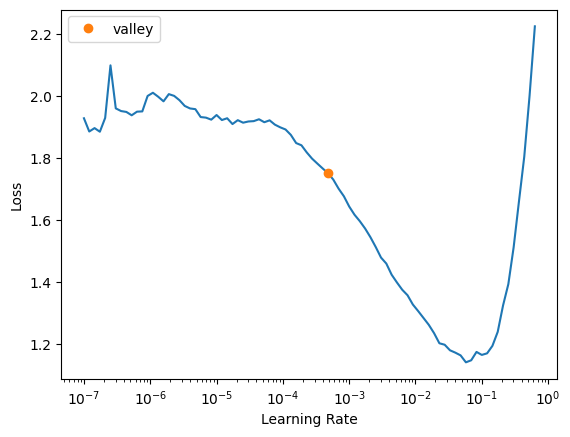

In [28]:

# Rebuilding the DataLoader and model
learn_tmp = vision_learner(dls, resnet18, metrics=accuracy)
learn_tmp.lr_find()

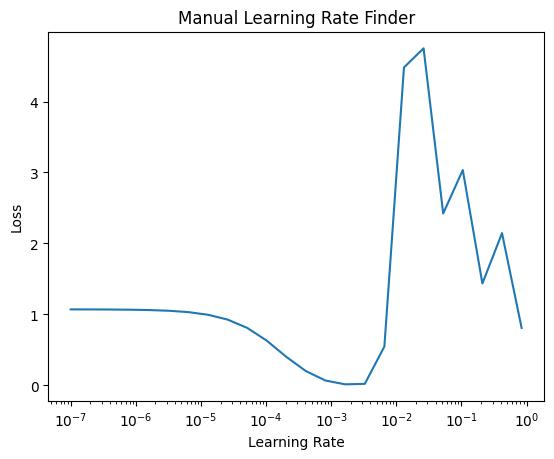

In [29]:
# B.2. Learning Rate Finder Algorithm
import torch
import matplotlib.pyplot as plt

lrs = []
losses = []
lr = 1e-7
max_lr = 1
factor = 2

# I’ll initialize the model as a new instance since the previously trained one might cause issues.
model = resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, len(dls.vocab))
model = model.to(dls.device)
model.train()
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = torch.nn.CrossEntropyLoss()
xb, yb = dls.one_batch()

# I’ll convert Fastai tensors into PyTorch tensors.
if hasattr(xb, 'as_subclass'):
    xb = xb.as_subclass(torch.Tensor)
if hasattr(yb, 'as_subclass'):
    yb = yb.as_subclass(torch.Tensor)

while lr < max_lr:
    opt.param_groups[0]['lr'] = lr
    opt.zero_grad()
    out = model(xb)
    loss = loss_func(out, yb)
    loss.backward()
    opt.step()
    lrs.append(lr)
    losses.append(loss.item())
    lr *= factor

plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Manual Learning Rate Finder')
plt.show()

## B.3. Transfer Learning ve Fine-tuning
In transfer learning, I replace the final linear layer of a pretrained model for the new task. First, I train only this new layer while freezing the rest, then I unfreeze the entire model and train it together

In [30]:
# B.3.1: Automatically replaces the model’s final layer (head) for the new task
learn_tl = vision_learner(dls, resnet18, metrics=accuracy)

# B.3.2: Just train (freezing) new final layer
learn_tl.freeze()
learn_tl.fit_one_cycle(3, 1e-3)

# B.3.3: TTrain (unfreezing) the entire network
learn_tl.unfreeze()
learn_tl.fit_one_cycle(3, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.873100,0.397726,0.866973,00:48
1,0.536995,0.295995,0.901376,00:49
2,0.342959,0.332868,0.892202,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.324618,0.232538,0.922018,01:04
1,0.253714,0.195678,0.922018,01:05
2,0.161832,0.265335,0.910550,01:05


## B.4. Discriminative Learning Rates
Discriminative learning rates let me use smaller learning rates for the early layers of the model and larger ones for the final layers. This way, the layers that learn general features update less, while the newly added layers update more.

In [16]:
# B.4.1: Fine-tuning with discriminative learning rates
learn_tl = vision_learner(dls, resnet18, metrics=accuracy)
learn_tl.freeze()
learn_tl.fit_one_cycle(3, 1e-3)

# B.4.2: Train with unfreeze and discriminative learning rates
# Low lr for early layers, high lr for final layers
learn_tl.unfreeze()
learn_tl.fit_one_cycle(5, lr_max=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.872661,0.388398,0.850917,00:50
1,0.487725,0.309320,0.880734,00:46
2,0.362188,0.299298,0.885321,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.264729,0.282775,0.889908,01:02
1,0.288196,0.280620,0.915138,01:02
2,0.216668,0.257703,0.919725,01:02
3,0.131396,0.258795,0.924312,01:02
4,0.082380,0.232091,0.933486,01:01


## B.5. Deciding the Number of Training Epochs
Once the right learning rate is chosen using the learning rate finder, it’s enough to just retrain your model. In Fastai, early stopping isn’t usually used because it can conflict with the learning rate finder and cause the model to stop too early at a wrong learning rate.

### B.5.2: Automatically Using the Suggested Learning Rate from lr_find
Here, I’m retraining the model using the suggested learning rate ("steep" point) from Fastai’s lr_find function.

Önerilen learning rate (minimum): 0.00831763744354248, (steep): 0.002511886414140463


epoch,train_loss,valid_loss,accuracy,time
0,0.785275,0.485546,0.850917,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.340661,0.287352,0.889908,01:05
1,0.262185,0.348686,0.873853,01:05
2,0.220035,0.351494,0.889908,01:05
3,0.169865,0.256369,0.922018,01:07
4,0.126196,0.271035,0.933486,01:05
5,0.097296,0.268408,0.922018,01:06
6,0.072702,0.254588,0.931193,01:06
7,0.047365,0.268512,0.928899,01:06
8,0.029684,0.227793,0.938073,01:07
9,0.027328,0.210944,0.940367,01:07


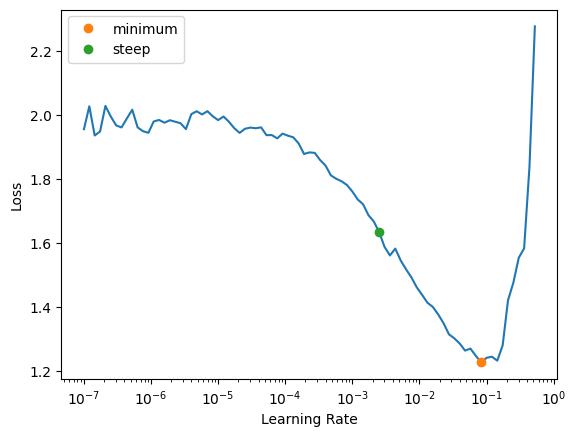

In [31]:
# B.5.2: I’ll retrain the model using the learning rate suggested by lr_find.
learn_auto = vision_learner(dls, resnet18, metrics=accuracy)
lr_min, lr_steep = learn_auto.lr_find(suggest_funcs=(minimum, steep))
print(f"Önerilen learning rate (minimum): {lr_min}, (steep): {lr_steep}")
learn_auto.fine_tune(10, base_lr=lr_steep)

## B.6. Model Capacity ve Batch Size
When increasing the model capacity, it’s important to reduce the batch size to save GPU memory. I can also use mixed precision training.

In [33]:
# B.6.1: Bigger model and smaller batch size.
bs = 16  # I reduced the batch size
learn_big = vision_learner(dls, resnet34, metrics=accuracy)
learn_big.dls = dblock.dataloaders(filtered_images, bs=bs)

# B.6.2:  I trained with mixed precision (if GPU is available).
learn_big.to_fp16()
learn_big.fine_tune(5, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.798622,0.353542,0.871560,01:29


epoch,train_loss,valid_loss,accuracy,time
0,0.434887,0.268582,0.885321,02:06
1,0.315860,0.251148,0.912844,01:58
2,0.245312,0.212640,0.924312,01:59
3,0.157749,0.195116,0.926606,01:58
4,0.110527,0.220648,0.926606,01:57


## Exporting the Trained Model
Export the trained model as a .pkl file for later inference or deployment. Bu export işlemi Linux/Colab/Hugging Face uyumludur.

In [ ]:
# Export the latest trained model (change 'learn_auto' to your final model variable if needed)
from pathlib import Path
learn_auto.dls.path = Path(str(learn_auto.dls.path))
learn_auto.export('shoe_classifier.pkl')
print("Model exported as 'shoe_classifier.pkl'")